# Geometric Brownian Motion Dataset

This script creates a synthetic dataset composed of Geometric Brownian Motion (GBM) time series, commonly used in financial modeling to simulate the stochastic behavior of asset prices. GBM is a continuous-time stochastic process that incorporates both deterministic and random components, making it particularly suited for modeling the unpredictable nature of stock prices and other financial instruments.

**Key Features of the Dataset:**

1. **Geometric Brownian Motion**: Each time series follows a GBM path, defined by a drift coefficient and a volatility coefficient. The drift represents the expected return, and the volatility represents the standard deviation of the return, mirroring real-world financial scenarios where assets have expected trends and fluctuating values.

2. **Vectorized Generation**: The series are generated in a vectorized manner, enhancing computational efficiency, particularly when generating a large number of time series over extensive time periods.

3. **Multiple Series with Different Paths**: The dataset includes numerous GBM series, each evolving independently based on its stochastic path. This mimics a diversified portfolio of assets in financial markets.

4. **Customizable Parameters**: Drift, volatility, and the number of time steps can be adjusted, allowing the simulation of various market conditions, from stable to highly volatile.

**Structure of the Dataset:**

- **series_id:** A unique identifier for each GBM time series, formatted as "series_i" where i is an integer.
- **time_step:** Represents the discrete time step in the series.
- **value:** The simulated stock price or asset value at each time step.

**Applications of the GBM Dataset:**

- **Financial Modeling and Simulation:** Ideal for simulating stock prices and other financial assets, providing a realistic framework for portfolio management, option pricing, and risk assessment.
- **Machine Learning and Forecasting:** The dataset can be used to train and evaluate models in predicting financial time series, offering both challenges and insights due to its stochastic nature.
- **Educational Tool:** Aids in understanding the principles of financial mathematics and stochastic processes, particularly in demonstrating the behavior of assets under different market conditions.

The GBM Dataset, with its realistic representation of asset price dynamics, serves as an essential resource for financial analysis, machine learning applications in finance, and for anyone seeking to understand or model the behavior of financial markets.

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import Tuple, Dict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_name = "geometric_brownian_motion"

In [3]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Functions to generate data

In [4]:
def generate_gbm_series(
        initial_value: float,
        drift: float,
        volatility: float,
        time_steps: int,
        dt: float,
        num_series: int
    ):
    """
    Generate multiple GBM series in a vectorized manner.

    Args:
        initial_value (float): The initial value of the series.
        drift (float): The drift coefficient.
        volatility (float): The volatility coefficient.
        time_steps (int): The number of time steps.
        dt (float): The time increment.
        num_series (int): The number of series to generate.

    Returns:
        np.ndarray: An array of GBM series.
    """
    # Generate random increments for all series and time steps at once
    random_increments = np.random.normal(0, 1, (num_series, time_steps - 1))

    # Calculate the exponent term for all series and time steps
    exponent = (drift - 0.5 * volatility ** 2) * dt + volatility * random_increments * np.sqrt(dt)

    # Initialize series array and set initial values
    series = np.zeros((num_series, time_steps))
    series[:, 0] = initial_value

    # Calculate GBM series in a vectorized form
    series[:, 1:] = initial_value * np.exp(np.cumsum(exponent, axis=1))

    return series

In [5]:
def convert_to_df(gbm_series: np.ndarray) -> pd.DataFrame:
    """
    Convert a 2-D array of GBM series into a pandas DataFrame.

    Args:
        gbm_series (np.ndarray): A 2-D array of GBM series with shape (num_series, time_steps).

    Returns:
        pd.DataFrame: A DataFrame with columns 'series_id', 'time', and 'value'.
    """
    num_series, time_steps = gbm_series.shape

    # Create 'series_id' and 'time' columns
    series_id = np.repeat([f'series_{i}' for i in range(num_series)], time_steps)
    time = np.tile(np.arange(1, time_steps + 1), num_series)

    # Flatten the values
    values = gbm_series.flatten()

    # Create DataFrame
    df = pd.DataFrame({'series_id': series_id, 'time': time, 'value': values})

    return df

# Generate Data

In [6]:
# set seed for reproducibility
np.random.seed(42)

# Parameters
initial_value = 100.
drift = 0.09 / 252
volatility = 0.25 / np.sqrt(252)
time_steps = 252 * 2 
dt = 1
num_series = 100

# Generate GBM series
gbm_series = generate_gbm_series(initial_value, drift, volatility, time_steps, dt, num_series)

# Calculate some stats
# Extract the final values from each series
final_vals = gbm_series[:, -1]

# Calculating statistics
avg_val = round(np.mean(final_vals), 3)
min_val = round(np.min(final_vals), 3)
max_val = round(np.max(final_vals), 3)
std_dev = round(np.std(final_vals), 3)
roi = round(avg_val / initial_value - 1, 3)
print(f"avg_ending_val={avg_val}, std_dev_val={std_dev}, min_val={min_val}, max_val={max_val}, roi={roi}" )

avg_ending_val=118.598, std_dev_val=38.421, min_val=43.613, max_val=254.768, roi=0.186


# Convert to DataFrame

In [7]:
data = convert_to_df(gbm_series)
data.tail()

,series_id,time,value
50395,series_99,500,132.768721
50396,series_99,501,130.933046
50397,series_99,502,130.876688
50398,series_99,503,131.833544
50399,series_99,504,131.306557


In [8]:
series_col = "series_id"
epoch_col = 'time'
time_col = None
value_col = 'value'
exog_cols=[]

# Visualize Data

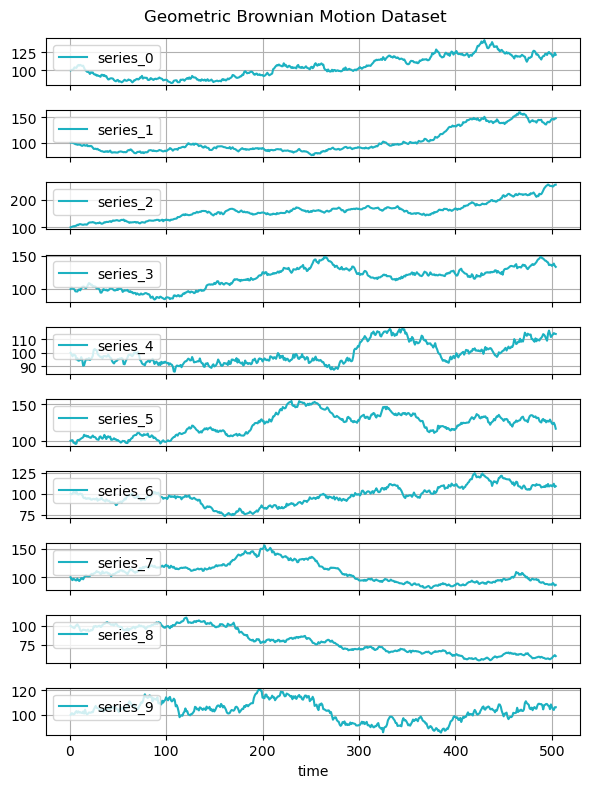

In [9]:
def visualize_series(df: pd.DataFrame, filename: str=None, max_series: int=10) -> None:
    """
    Visualizes the series in the provided DataFrame using subplots and saves the plot as a PNG file.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the series data with columns series_id, t, and y.
    - filename (str): Name of the file to save the plot.
    
    Returns:
    - None
    """
    t = df[epoch_col].unique()
    unique_series = sorted(df[series_col].unique())
    
    fig, axes = plt.subplots(nrows=len(unique_series[:max_series]), ncols=1, figsize=(6, 8), sharex=True)

    for i, _ in enumerate(unique_series[:max_series]):
        series_id = f"series_{i}"
        y = df[df[series_col] == series_id][value_col].values
        axes[i].plot(t, y, label=series_id, color="#1db1c1")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel(epoch_col)
    fig.suptitle("Geometric Brownian Motion Dataset", y=0.98)
    plt.tight_layout()
    
    # Save the figure
    if filename is not None:
        plt.savefig(filename)
        
# Visualize
visualize_series(data, outp_fig_fname, max_series=10)

# Save Main Data File

In [10]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False, float_format="%.3f")